# Dropout param post processing

In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor

from matplotlib.colors import LogNorm

%matplotlib inline


def trace_plot(chain, pars,
               cols=3, wid_per_col=6, aspect=4/3,
               kwargs={}):

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=6, aspect=4/3,
              kwargs={}):
    hist_kwargs = {
        'normed':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

In [39]:
rundir = '/home/pbaker/nanograv/bwm/tests/9y_dropout/'
#rundir = '/home/pbaker/nanograv/bwm/tests/11y_dropout/'

In [40]:
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip() for line in f]

# BWM params
par_bwm = []
idx_bwm = []
for pp, par in enumerate(params):
    if 'bwm' in par and 'psrk' not in par:
        par_bwm.append(par)
        idx_bwm.append(pp)

# dropout params
idx_k = []
par_k = []
for par in params:
    if "psrk" in par:
        idx_k.append(params.index(par))
        par_k.append(par)

In [41]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                sep='\t', dtype=float, header=None).values

In [42]:
burnfrac = 0.15
thin = 25

burn = int(burnfrac * len(chain_raw))

ch_bwm = chain_raw[burn::thin, idx_bwm]
ch_k = chain_raw[burn::thin, idx_k]
ch_like = chain_raw[burn::thin, -4]

corL = acor(ch_like)[0]
N = len(ch_bwm)
print("N = {}, corL = {}".format(N, corL))

N = 8980, corL = 4.47186015782


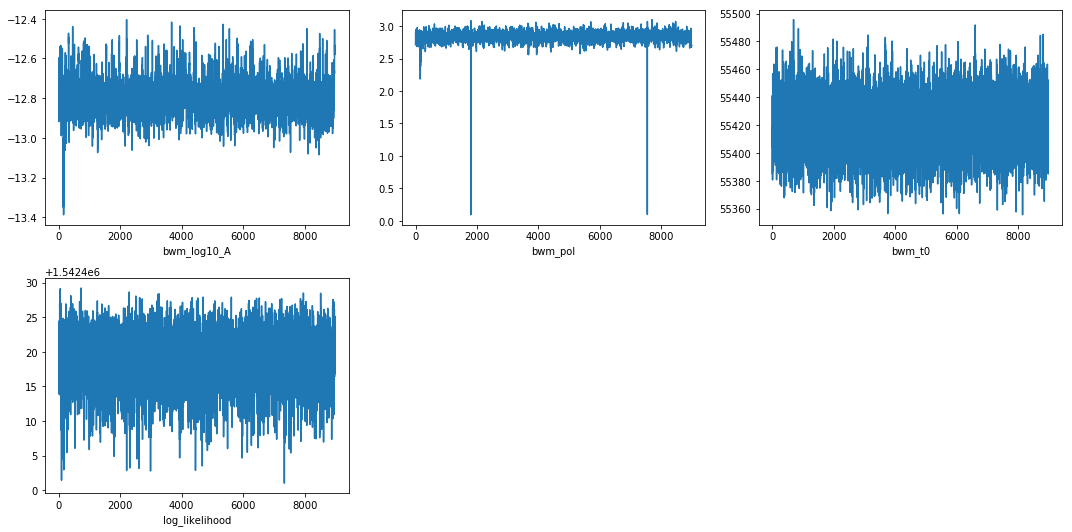

In [43]:
trace_plot(np.hstack((ch_bwm, ch_like.reshape(len(ch_like),1))),
           par_bwm + ['log_likelihood'],
           cols=3, wid_per_col=5);

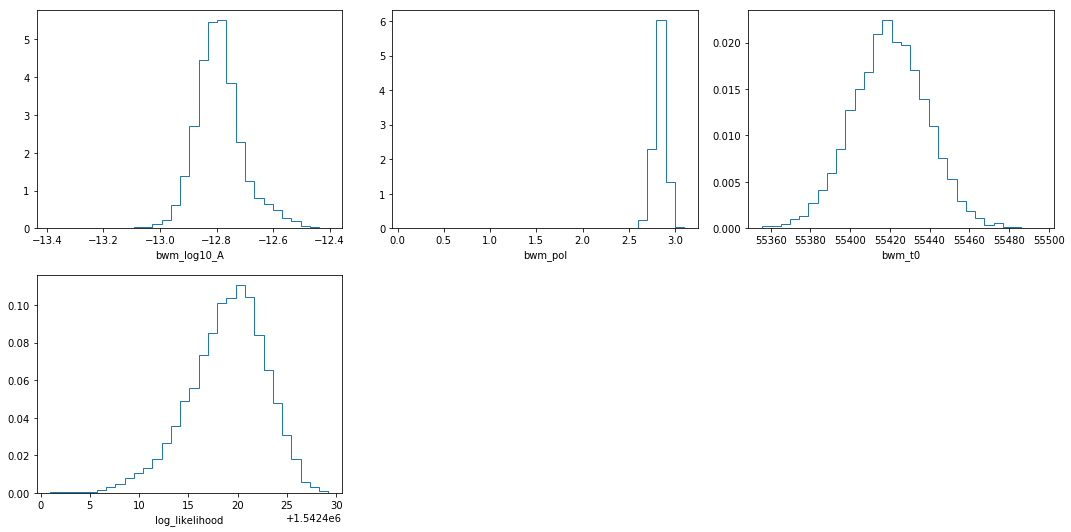

In [44]:
hist_plot(np.hstack((ch_bwm, ch_like.reshape(len(ch_like),1))),
           par_bwm + ['log_likelihood'],
           cols=3, wid_per_col=5);

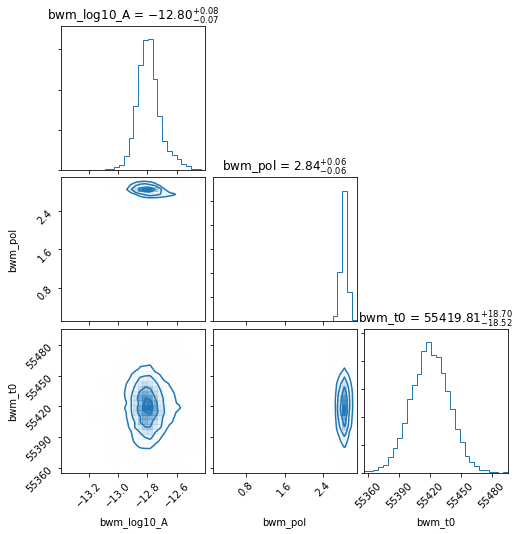

In [45]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.50,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(ch_bwm, color='C0', **corner_kwargs);

## dropout param plots

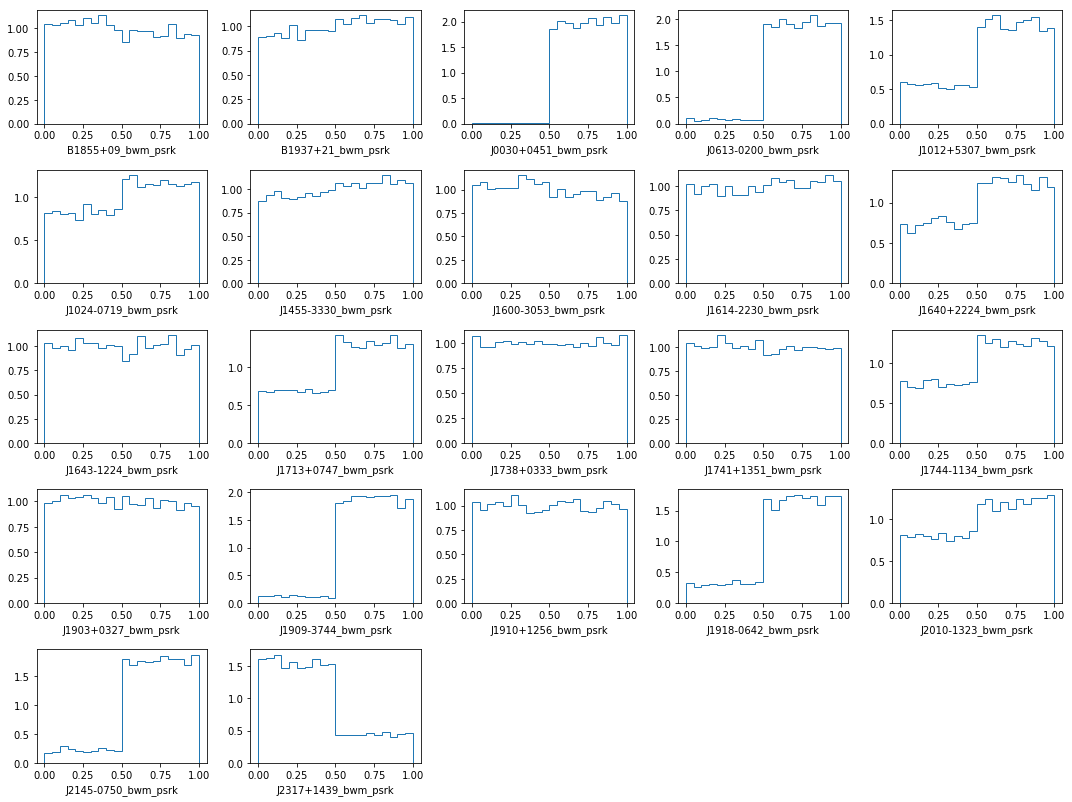

In [46]:
hist_plot(ch_k,
          par_k,
          cols=5, wid_per_col=3,
          bins=np.linspace(0,1,21));

In [47]:
Os = []
psrnames = []
for p, par in enumerate(par_k):
    on = sum(np.rint(ch_k[:,p]))/len(ch_k)
    off = 1 - on
    odds = on/off
    psrname = par.split('_')[0]
    psrnames.append(psrname)
    Os.append(odds)
    if psrname[0]=='B':
        psrname = '  '+psrname
    print("{:s} on frac = {:.2f}, Odds = {:.2f}".format(psrname, on, odds))
Os = np.array(Os)
psrnames = np.array(psrnames)
ii = np.argsort(Os)

  B1855+09 on frac = 0.47, Odds = 0.89
  B1937+21 on frac = 0.53, Odds = 1.14
J0030+0451 on frac = 0.99, Odds = 165.30
J0613-0200 on frac = 0.96, Odds = 24.73
J1012+5307 on frac = 0.72, Odds = 2.60
J1024-0719 on frac = 0.59, Odds = 1.42
J1455-3330 on frac = 0.53, Odds = 1.14
J1600-3053 on frac = 0.47, Odds = 0.89
J1614-2230 on frac = 0.52, Odds = 1.08
J1640+2224 on frac = 0.63, Odds = 1.70
J1643-1224 on frac = 0.49, Odds = 0.98
J1713+0747 on frac = 0.66, Odds = 1.92
J1738+0333 on frac = 0.50, Odds = 1.00
J1741+1351 on frac = 0.49, Odds = 0.95
J1744-1134 on frac = 0.63, Odds = 1.70
J1903+0327 on frac = 0.49, Odds = 0.97
J1909-3744 on frac = 0.94, Odds = 15.69
J1910+1256 on frac = 0.50, Odds = 1.01
J1918-0642 on frac = 0.84, Odds = 5.38
J2010-1323 on frac = 0.60, Odds = 1.51
J2145-0750 on frac = 0.89, Odds = 8.18
J2317+1439 on frac = 0.22, Odds = 0.28


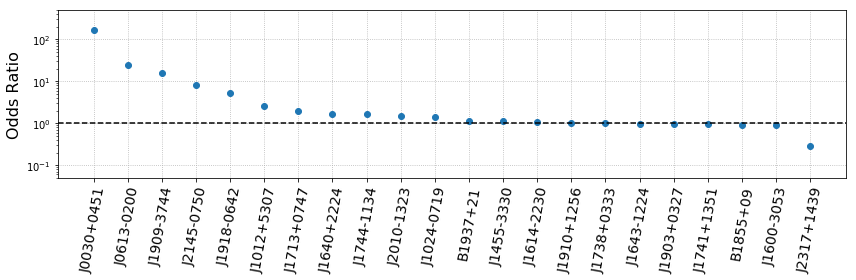

In [48]:
xs = np.arange(len(Os))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)

ax.plot(xs, Os[ii[::-1]], linestyle='none', marker='o')
ax.axhline(y=1, color='k', ls='--')

ax.set_xticks(xs)
ax.set_xticklabels(psrnames[ii[::-1]], rotation=80, fontsize=14)
if '9y' in rundir: ax.set_ylim([1/20, 500])  # 9yr
else: ax.set_ylim([1/20, 500])  # 11yr

ax.set_ylabel('Odds Ratio', fontsize=16)
ax.set_yscale('log')
ax.grid(ls=':')

fig.tight_layout()

if '9y' in rundir:
    fig.savefig("/home/pbaker/dropout_9yr.pdf")
else:
    fig.savefig("/home/pbaker/dropout_11yr.pdf")

In [ ]:
sig_psrs = [
    'J0030+0451',
    'J0613-0200',
    'J1909-3744',
    'J2145-0750',
    'J1918-0642',
    'J1012+5307',
]
#'B1937+21', 'J2317+1439']

par_sig = []
idx_sig = []
for psr in sig_psrs:
    for par in par_k:
        if psr in par:
            idx_sig.append(par_k.index(par))
            par_sig.append(par.split('_')[0])

In [ ]:
hist_plot(ch_k[:,idx_sig],
          par_sig,
          cols=3, wid_per_col=4, aspect=1.1,
          bins=np.linspace(0,1,15));

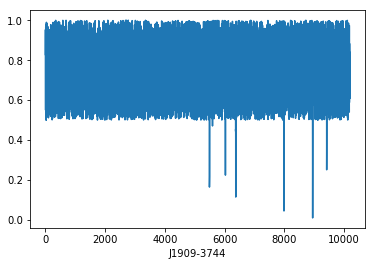

In [36]:
#psr = 'J0030+0451'
psr = 'J1909-3744'

for par in par_k:
    if psr in par:
        idx_psr = par_k.index(par)
        par_psr = par.split('_')[0]

plt.plot(ch_k[:,idx_psr])
plt.xlabel(par_psr);